In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import math
import random
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.utils import to_categorical
import os
from sklearn.impute import KNNImputer



# WOA
!pip install pyMetaheuristic
from pyMetaheuristic.algorithm import whale_optimization_algorithm
from pyMetaheuristic.utils import graphs

dataset = pd.read_csv('/content/drive/MyDrive/Credit_scorr_data/train.csv')

<ipython-input-2-a446399bc990>:31: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('/content/drive/MyDrive/Credit_scorr_data/train.csv')


#Data Cleaning and Preprocessing

In [4]:
dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
dataset['Credit_Mix']=(dataset['Credit_Mix'].apply(lambda x : np.NaN if x== '_' else x))


dataset['Credit_Mix']=dataset.groupby('Customer_ID')['Credit_Mix'].transform(
    lambda v: v.mode()[0]).astype('category')
dataset['Credit_Mix'].unique()

['Good', 'Standard', 'Bad']
Categories (3, object): ['Bad', 'Good', 'Standard']

In [6]:
dataset['Payment_Behaviour']=(dataset['Payment_Behaviour'].apply(lambda x : np.NaN if x== '!@9#%8' else x))

dataset['Payment_Behaviour']=dataset.groupby('Customer_ID')['Payment_Behaviour'].transform(
    lambda v: v.mode()[0]).astype('category')

dataset['Payment_Behaviour'].unique()

['High_spent_Medium_value_payments', 'High_spent_Large_value_payments', 'High_spent_Small_value_payments', 'Low_spent_Large_value_payments', 'Low_spent_Small_value_payments', 'Low_spent_Medium_value_payments']
Categories (6, object): ['High_spent_Large_value_payments', 'High_spent_Medium_value_payments',
                         'High_spent_Small_value_payments', 'Low_spent_Large_value_payments',
                         'Low_spent_Medium_value_payments', 'Low_spent_Small_value_payments']

In [7]:
dataset['Type_of_Loan'] = (
    dataset['Type_of_Loan'].str.replace(', ', ',').str.replace('and ', '')
)
dataset['Type_of_Loan'] = (
    dataset.groupby('Customer_ID')['Type_of_Loan'].fillna(
        lambda v: v.mode()[0])
)

In [8]:
dataset['Payment_of_Min_Amount'] = (
    dataset['Payment_of_Min_Amount'].str.replace('NM', 'No').astype("category")
)


In [9]:
dataset.drop(["Name" , "Customer_ID" , "ID" , "SSN"],axis=1 , inplace=True,
             errors="ignore")

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Month                     100000 non-null  object  
 1   Age                       100000 non-null  object  
 2   Occupation                100000 non-null  object  
 3   Annual_Income             100000 non-null  object  
 4   Monthly_Inhand_Salary     84998 non-null   float64 
 5   Num_Bank_Accounts         100000 non-null  int64   
 6   Num_Credit_Card           100000 non-null  int64   
 7   Interest_Rate             100000 non-null  int64   
 8   Num_of_Loan               100000 non-null  object  
 9   Type_of_Loan              100000 non-null  object  
 10  Delay_from_due_date       100000 non-null  int64   
 11  Num_of_Delayed_Payment    92998 non-null   object  
 12  Changed_Credit_Limit      100000 non-null  object  
 13  Num_Credit_Inquiries      9803

Credit_score_distribution: 


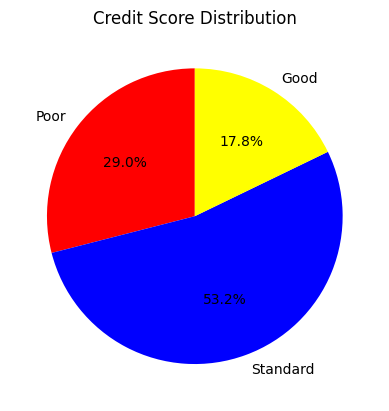

In [11]:
print("Credit_score_distribution: ")
labels= ['Poor', 'Standard', 'Good']
colors=[ 'red' , 'blue' , 'yellow']
credit=[dataset['Credit_Score'].value_counts()['Poor'],
        dataset['Credit_Score'].value_counts()['Standard'],
        dataset['Credit_Score'].value_counts()['Good']]
plt.pie(credit,labels=labels,colors=colors,startangle=90, autopct='%1.1f%%')
plt.title("Credit Score Distribution")
plt.show()

In [12]:
missing_percent=dataset.isnull().sum()*100/len(dataset)
print(missing_percent)

Month                        0.000
Age                          0.000
Occupation                   0.000
Annual_Income                0.000
Monthly_Inhand_Salary       15.002
Num_Bank_Accounts            0.000
Num_Credit_Card              0.000
Interest_Rate                0.000
Num_of_Loan                  0.000
Type_of_Loan                 0.000
Delay_from_due_date          0.000
Num_of_Delayed_Payment       7.002
Changed_Credit_Limit         0.000
Num_Credit_Inquiries         1.965
Credit_Mix                   0.000
Outstanding_Debt             0.000
Credit_Utilization_Ratio     0.000
Credit_History_Age           9.030
Payment_of_Min_Amount        0.000
Total_EMI_per_month          0.000
Amount_invested_monthly      4.479
Payment_Behaviour            0.000
Monthly_Balance              1.200
Credit_Score                 0.000
dtype: float64


In [13]:
for i in dataset.columns:
  if dataset[i].dtype== type(object):
    print(i , end=': ')
    print('\n',dataset[i].unique())
    print()

Month: 
 ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

Age: 
 ['23' '-500' '28_' ... '4808_' '2263' '1342']

Occupation: 
 ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']

Annual_Income: 
 ['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_']

Num_of_Loan: 
 ['4' '1' '3' '967' '-100' '0' '0_' '2' '3_' '2_' '7' '5' '5_' '6' '8' '8_'
 '9' '9_' '4_' '7_' '1_' '1464' '6_' '622' '352' '472' '1017' '945' '146'
 '563' '341' '444' '720' '1485' '49' '737' '1106' '466' '728' '313' '843'
 '597_' '617' '119' '663' '640' '92_' '1019' '501' '1302' '39' '716' '848'
 '931' '1214' '186' '424' '1001' '1110' '1152' '457' '1433' '1187' '52'
 '1480' '1047' '1035' '1347_' '33' '193' '699' '329' '1451' '484' '132'
 '649' '995' '545' '684' '1135' '1094' '1204' '654' '58' '348' '614'
 '1363' '323' '1406' '1348' '430' '153' '1461' '

In [14]:
try:
    dataset['Monthly_Balance'] = pd.to_numeric(dataset['Monthly_Balance'])
except ValueError as e:
    print(f"Error: {e}")
    error_rows = dataset[pd.to_numeric(dataset['Monthly_Balance'], errors='coerce').isna()]
    print("Rows causing the error:")
    print(error_rows['Monthly_Balance'].unique())

Error: Unable to parse string "__-333333333333333333333333333__" at position 5545
Rows causing the error:
[nan '__-333333333333333333333333333__']


In [15]:
dataset.iloc[5545]

Month                                                                February
Age                                                                        17
Occupation                                                          Developer
Annual_Income                                                         41086.4
Monthly_Inhand_Salary                                             3660.866667
Num_Bank_Accounts                                                           3
Num_Credit_Card                                                             4
Interest_Rate                                                               6
Num_of_Loan                                                                 7
Type_of_Loan                Home Equity Loan,Not Specified,Mortgage Loan,P...
Delay_from_due_date                                                        10
Num_of_Delayed_Payment                                                     17
Changed_Credit_Limit                                            

In [16]:
def text_to_months(text):
  if pd.isna(text):
    return 0
  word=text.split()
  year=int(word[0])
  months=0
  if (len(word)>3):
      months=int(word[3])

  total_months=12*year + months
  return total_months

dataset['Credit_History_Age']=dataset['Credit_History_Age'].apply(text_to_months)
dataset.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,January,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan,Credit-Builder Loan,Personal Loan,Ho...",...,Good,809.98,26.822620,265,No,49.574949,80.41529543900253,High_spent_Medium_value_payments,312.49408867943663,Good
1,February,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan,Credit-Builder Loan,Personal Loan,Ho...",...,Good,809.98,31.944960,0,No,49.574949,118.28022162236736,High_spent_Medium_value_payments,284.62916249607184,Good
2,March,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan,Credit-Builder Loan,Personal Loan,Ho...",...,Good,809.98,28.609352,267,No,49.574949,81.699521264648,High_spent_Medium_value_payments,331.2098628537912,Good
3,April,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan,Credit-Builder Loan,Personal Loan,Ho...",...,Good,809.98,31.377862,268,No,49.574949,199.4580743910713,High_spent_Medium_value_payments,223.45130972736786,Good
4,May,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan,Credit-Builder Loan,Personal Loan,Ho...",...,Good,809.98,24.797347,269,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [17]:
def replace_special_character(text):
   if "NM" in str(text):
      return 'No'
   if "payments" in str(text) or "_" not in str(text):
    return text
   clean_text=str(text).replace("_",".")

   try:
    clean_text=pd.to_numeric(clean_text)
   except ValueError as e:
    clean_text=np.nan
   return np.nan if clean_text=='nan' or clean_text==" " else clean_text

In [18]:
dataset['Age']=pd.to_numeric(dataset['Age'].apply(replace_special_character))
dataset['Annual_Income'] = pd.to_numeric(dataset['Annual_Income'].apply(replace_special_character))
dataset['Changed_Credit_Limit'] = pd.to_numeric(dataset['Changed_Credit_Limit'].apply(replace_special_character))
dataset['Outstanding_Debt'] = pd.to_numeric(dataset['Outstanding_Debt'].apply(replace_special_character))
dataset['Num_of_Delayed_Payment'] = pd.to_numeric(dataset['Num_of_Delayed_Payment'].apply(replace_special_character))
dataset['Amount_invested_monthly'] = pd.to_numeric(dataset['Amount_invested_monthly'].apply(replace_special_character))
dataset['Monthly_Balance'] =  pd.to_numeric(dataset['Monthly_Balance'].apply(replace_special_character))
dataset['Num_of_Loan'] =  pd.to_numeric(dataset['Num_of_Loan'].apply(replace_special_character))

In [19]:
def print_column_range(column_name, min_value, max_value):
    print(f"{column_name.replace('_', ' '):<25} | {min_value:^10} - {max_value:^10}")
print("-" * 40)
print("Column Name           |   Range   ")
print("-" * 40)
columns=['Age' , 'Annual_Income' , 'Monthly_Inhand_Salary' , 'Num_Bank_Accounts' , 'Num_Credit_Card' , 'Interest_Rate' , 'Delay_from_due_date' ,
         'Num_of_Delayed_Payment' , 'Num_Credit_Inquiries' , 'Outstanding_Debt' , 'Credit_Utilization_Ratio' , 'Total_EMI_per_month' ,
         'Amount_invested_monthly' , 'Monthly_Balance', 'Num_of_Loan']
for column in columns:
    print_column_range(column, dataset[column].min(), dataset[column].max())

print("-" * 40)


----------------------------------------
Column Name           |   Range   
----------------------------------------
Age                       |   -500.0   -   8698.0  
Annual Income             |  7005.93   - 24198062.0
Monthly Inhand Salary     | 303.6454166666666 - 15204.633333333331
Num Bank Accounts         |     -1     -    1798   
Num Credit Card           |     0      -    1499   
Interest Rate             |     1      -    5797   
Delay from due date       |     -5     -     67    
Num of Delayed Payment    |    -3.0    -   4397.0  
Num Credit Inquiries      |    0.0     -   2597.0  
Outstanding Debt          |    0.23    -  4998.07  
Credit Utilization Ratio  |    20.0    - 50.00000000000001
Total EMI per month       |    0.0     -  82331.0  
Amount invested monthly   |    0.0     - 1977.326102249349
Monthly Balance           | 0.0077596647753352 - 1602.0405189622518
Num of Loan               |   -100.0   -   1496.0  
----------------------------------------


In [20]:
def remove_outliners(x,f):
  try:
    x=pd.to_numeric(x,errors='raise')

    if x<0:
      return np.nan
    else:
      if f=='age':
        if x>100:
          return np.nan
        else:
          return x
      else:
        return x
  except ValueError:
    return np.nan


In [21]:
dataset['Age']=dataset.apply(lambda x: remove_outliners(x['Age'] , 'age') , axis =1)
dataset['Num_of_Delayed_Payment'] = dataset.apply(lambda x: remove_outliners(x['Num_of_Delayed_Payment'], 'none'), axis=1)
dataset['Num_of_Loan'] = dataset.apply(lambda x: remove_outliners(x['Num_of_Loan'], 'none'), axis=1)

In [22]:
from sklearn.impute import KNNImputer
knn=KNNImputer(n_neighbors=5)
nums=[cols for cols in dataset.columns if dataset[cols].dtypes=='float64']
new_dataset=knn.fit_transform(dataset[nums])
data=pd.DataFrame(new_dataset,columns=nums)
data.head(5)

,Age,Annual_Income,Monthly_Inhand_Salary,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
0,23.0,19114.12,1824.843333,4.0,7.0,11.270,4.0,809.98,26.822620,49.574949,80.415295,312.494089
1,23.0,19114.12,1464.844833,4.0,13.2,11.270,4.0,809.98,31.944960,49.574949,118.280222,284.629162
2,33.2,19114.12,1909.822250,4.0,7.0,9.836,4.0,809.98,28.609352,49.574949,81.699521,331.209863
3,23.0,19114.12,1913.479000,4.0,4.0,6.270,4.0,809.98,31.377862,49.574949,199.458074,223.451310
4,23.0,19114.12,1824.843333,4.0,6.8,11.270,4.0,809.98,24.797347,49.574949,41.420153,341.489231


In [23]:
for cols in nums:
  dataset[cols]=data[cols]

In [24]:
df_dummies = dataset['Type_of_Loan'].str.get_dummies(sep=',')
dataset = dataset.drop(columns='Type_of_Loan')
dataset = pd.concat([dataset, df_dummies], axis=1)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count   Dtype
---  ------                                 --------------   -----
 0   <function <lambda> at 0x79c060b8a3b0>  100000 non-null  int64
 1   Auto Loan                              100000 non-null  int64
 2   Credit-Builder Loan                    100000 non-null  int64
 3   Debt Consolidation Loan                100000 non-null  int64
 4   Home Equity Loan                       100000 non-null  int64
 5   Mortgage Loan                          100000 non-null  int64
 6   Not Specified                          100000 non-null  int64
 7   Payday Loan                            100000 non-null  int64
 8   Personal Loan                          100000 non-null  int64
 9   Student Loan                           100000 non-null  int64
dtypes: int64(10)
memory usage: 7.6 MB


In [25]:
dataset.dropna(inplace=True)
dataset["Age"] = pd.to_numeric(dataset["Age"])
dataset["Annual_Income"] = pd.to_numeric(dataset["Annual_Income"])
dataset["Num_of_Delayed_Payment"] = pd.to_numeric(dataset["Num_of_Delayed_Payment"])
dataset["Changed_Credit_Limit"] = pd.to_numeric(dataset["Changed_Credit_Limit"])
dataset["Outstanding_Debt"] = pd.to_numeric(dataset["Outstanding_Debt"])
dataset["Amount_invested_monthly"] = pd.to_numeric(dataset["Amount_invested_monthly"])
dataset["Monthly_Balance"] = pd.to_numeric(dataset["Monthly_Balance"])

In [26]:
dataset['Occupation'] = dataset['Occupation'].replace('_______', 'other')
dataset['Occupation'] .unique()

array(['Scientist', 'other', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [27]:
print("Credit Score Class Distribution")
print("Poor: ",dataset['Credit_Score'].value_counts()['Poor'])
print("Standard: ",dataset['Credit_Score'].value_counts()['Standard'])
print("Good: ",dataset['Credit_Score'].value_counts()['Good'])

Credit Score Class Distribution
Poor:  28998
Standard:  53174
Good:  17828


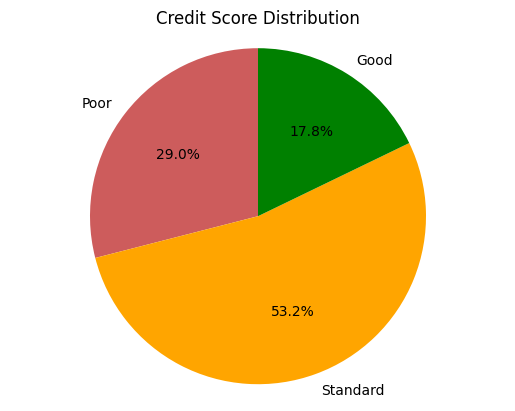

In [28]:
labels= ['Poor', 'Standard', 'Good']
colors=['indianred', 'orange', 'green']
credit = [dataset['Credit_Score'].value_counts()['Poor'],dataset['Credit_Score'].value_counts()['Standard'],dataset['Credit_Score'].value_counts()['Good']]
plt.pie(credit,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Credit Score Distribution')
plt.show()

In [29]:
for column in dataset.select_dtypes(include='object').columns:
    print(column)
    print(dataset[column].unique())
    print('\n')

Month
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


Occupation
['Scientist' 'other' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']


Credit_Score
['Good' 'Standard' 'Poor']




#Encoding

In [30]:
m = {
    'Bad' : 0,
    'Standard' : 1,
    'Good' : 2,
    }
dataset['Credit_Mix'] = (dataset['Credit_Mix'].map(m))

dataset['Credit_Mix'] = (dataset['Credit_Mix'].astype("int64"))

In [31]:
m = {
    'Low_spent_Small_value_payments' : 0,
    'Low_spent_Medium_value_payments' : 1,
    'Low_spent_Large_value_payments' : 2,
    'High_spent_Small_value_payments' : 3,
    'High_spent_Medium_value_payments' : 4,
    'High_spent_Large_value_payments' : 5
    }

dataset['Payment_Behaviour'] = (dataset['Payment_Behaviour'].map(m))

dataset['Payment_Behaviour'] = (dataset['Payment_Behaviour'].astype("int64"))

In [32]:
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   RobustScaler
                                  )

In [33]:
le=LabelEncoder()

le.fit(dataset['Credit_Score'])
dataset['Credit_Score']=le.transform(dataset['Credit_Score'])


In [34]:
def separate_age_groups(row):
    if row['Age'] >= 0 and row['Age'] <=26:
        return 'Young(14-26)'
    elif row['Age'] >= 27 and row['Age'] <=59:
        return 'Adult(27-59)'
    else:
        return 'Elderly(60-100)'

dataset['Age_Group'] = (
    dataset.apply(separate_age_groups, axis=1)
)

dataset['Age_Group'] = (
    dataset['Age_Group'].astype("category")
)


In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   Month                                  100000 non-null  object  
 1   Age                                    100000 non-null  float64 
 2   Occupation                             100000 non-null  object  
 3   Annual_Income                          100000 non-null  float64 
 4   Monthly_Inhand_Salary                  100000 non-null  float64 
 5   Num_Bank_Accounts                      100000 non-null  int64   
 6   Num_Credit_Card                        100000 non-null  int64   
 7   Interest_Rate                          100000 non-null  int64   
 8   Num_of_Loan                            100000 non-null  float64 
 9   Delay_from_due_date                    100000 non-null  int64   
 10  Num_of_Delayed_Payment                 100000

In [36]:
enc = OneHotEncoder(sparse=False, drop='if_binary')

In [37]:

variables_categoricas = dataset[['Payment_of_Min_Amount',
                                   'Age_Group']]
variables_enc = enc.fit_transform(variables_categoricas)
df_1 = pd.DataFrame(
    variables_enc, columns=enc.get_feature_names_out(variables_categoricas.columns)
)
df_1.rename(columns={'Payment_of_Min_Amount_Yes' : 'Payment_of_Min_Amount'}, inplace=True)
print(df_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Payment_of_Min_Amount      100000 non-null  float64
 1   Age_Group_Adult(27-59)     100000 non-null  float64
 2   Age_Group_Elderly(60-100)  100000 non-null  float64
 3   Age_Group_Young(14-26)     100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
dataset.drop(['Payment_of_Min_Amount', 'Age_Group'], axis=1, inplace=True)

In [39]:
rs = RobustScaler()

In [40]:
new_cols = dataset[['Annual_Income',
                                 'Monthly_Inhand_Salary',
                                 'Num_Bank_Accounts',
                                 'Num_Credit_Card',
                                 'Num_of_Loan',
                                 'Delay_from_due_date',
                                 'Num_of_Delayed_Payment',
                                 'Changed_Credit_Limit',
                                 'Num_Credit_Inquiries',
                                 'Outstanding_Debt',
                                 'Credit_Utilization_Ratio',
                                 'Credit_History_Age',
                                 'Total_EMI_per_month',
                                 'Amount_invested_monthly',
                                 'Monthly_Balance']]


variables_rs = rs.fit_transform(new_cols)
df_rs = pd.DataFrame(
    variables_rs, columns=rs.get_feature_names_out(new_cols.columns)
)

print(df_rs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Annual_Income             100000 non-null  float64
 1   Monthly_Inhand_Salary     100000 non-null  float64
 2   Num_Bank_Accounts         100000 non-null  float64
 3   Num_Credit_Card           100000 non-null  float64
 4   Num_of_Loan               100000 non-null  float64
 5   Delay_from_due_date       100000 non-null  float64
 6   Num_of_Delayed_Payment    100000 non-null  float64
 7   Changed_Credit_Limit      100000 non-null  float64
 8   Num_Credit_Inquiries      100000 non-null  float64
 9   Outstanding_Debt          100000 non-null  float64
 10  Credit_Utilization_Ratio  100000 non-null  float64
 11  Credit_History_Age        100000 non-null  float64
 12  Total_EMI_per_month       100000 non-null  float64
 13  Amount_invested_monthly   100000 non-null  fl

In [41]:
df_rs.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05
mean,2.599881,0.252485,2.772820,5.824810,1.377859,0.170488,1.916065,1.049641e-01,3.610112,0.188688,-0.002441,-0.038082,10.188614,3.972498e-01,3.262595e-01
std,26.225745,0.733507,29.351209,43.019137,19.778942,0.825561,24.459509,7.184419e-01,31.925022,0.835767,0.605971,0.642251,63.444808,1.201622e+00,1.064970e+00
min,-0.572966,-0.647410,-1.750000,-1.666667,-1.000000,-1.277778,-1.555556,-1.688842e+00,-1.000000,-0.846061,-1.457324,-1.168539,-0.528955,-7.996486e-01,-1.681466e+00
25%,-0.338298,-0.338622,-0.750000,-0.333333,-0.333333,-0.444444,-0.555556,-4.274176e-01,-0.500000,-0.432908,-0.503691,-0.528090,-0.297461,-3.456951e-01,-3.339113e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.437980e-17,0.000000,0.000000,0.000000,0.000000,0.000000,-8.760226e-17,1.418069e-16
75%,0.661702,0.661378,0.250000,0.666667,0.666667,0.555556,0.444444,5.725824e-01,0.500000,0.567092,0.496309,0.471910,0.702539,6.543049e-01,6.660887e-01
max,452.794694,2.832723,448.000000,498.000000,497.666667,2.722222,487.000000,2.929649e+00,431.833333,2.778307,2.095454,1.101124,628.347584,1.138951e+01,6.311777e+00


In [42]:
df_vr = dataset[['Credit_Mix',
                   'Payment_Behaviour',
                   'Auto Loan',
                   'Credit-Builder Loan',
                   'Debt Consolidation Loan',
                   'Home Equity Loan',
                   'Mortgage Loan',
                   'Not Specified',
                   'Payday Loan',
                   'Personal Loan',
                   'Student Loan',
                   'Credit_Score']]

In [43]:
df_credit_end = pd.concat([df_rs, df_1, df_vr], axis=1)

df_credit_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Annual_Income              100000 non-null  float64
 1   Monthly_Inhand_Salary      100000 non-null  float64
 2   Num_Bank_Accounts          100000 non-null  float64
 3   Num_Credit_Card            100000 non-null  float64
 4   Num_of_Loan                100000 non-null  float64
 5   Delay_from_due_date        100000 non-null  float64
 6   Num_of_Delayed_Payment     100000 non-null  float64
 7   Changed_Credit_Limit       100000 non-null  float64
 8   Num_Credit_Inquiries       100000 non-null  float64
 9   Outstanding_Debt           100000 non-null  float64
 10  Credit_Utilization_Ratio   100000 non-null  float64
 11  Credit_History_Age         100000 non-null  float64
 12  Total_EMI_per_month        100000 non-null  float64
 13  Amount_invested_monthly    100

In [44]:
df_credit_end['Credit_Score'].unique()

array([0, 2, 1])

<Axes: >

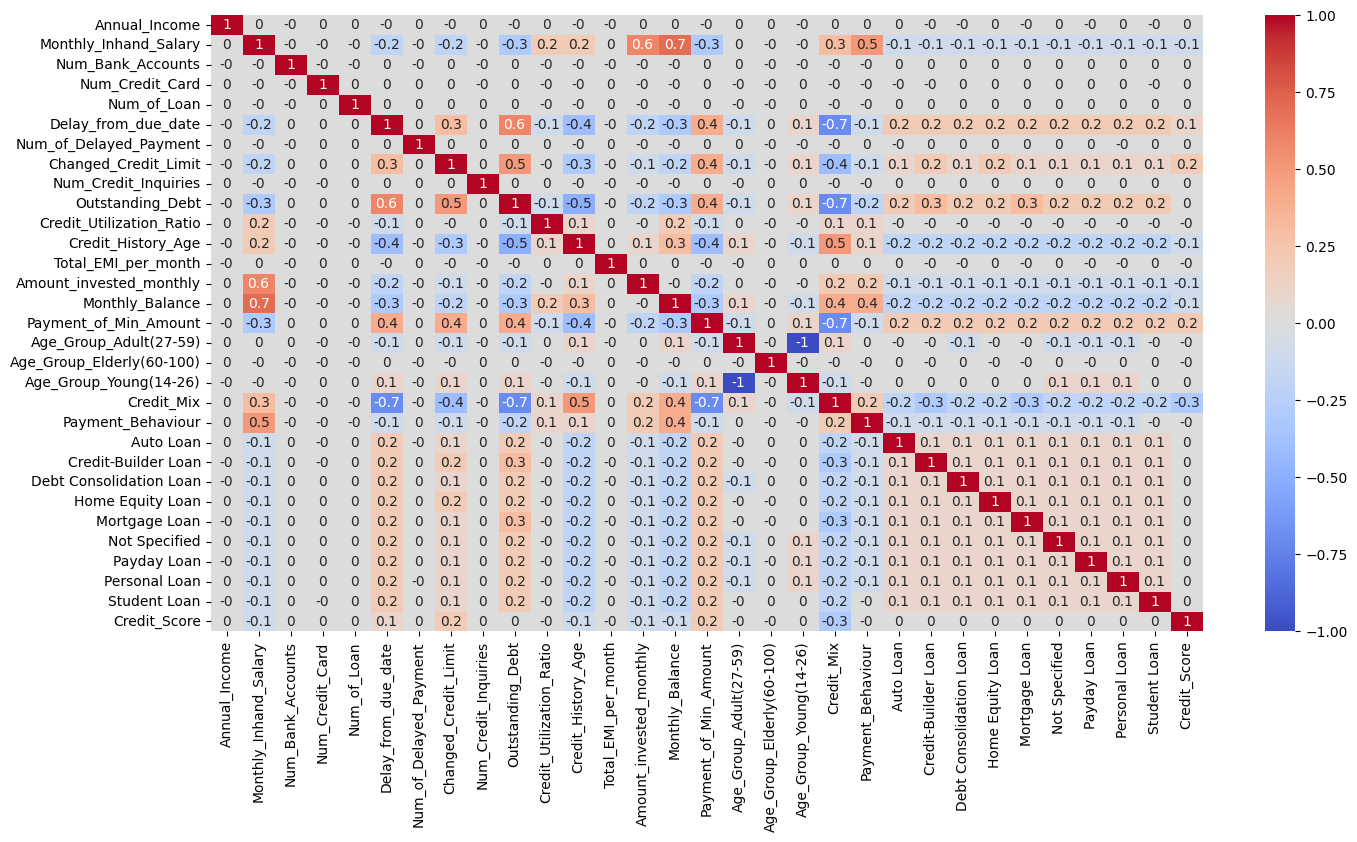

In [45]:
matrix = df_credit_end.corr(numeric_only=True).round(1)

plt.figure(figsize=(16, 8))

sns.heatmap(matrix, annot=True, cmap="coolwarm")

In [46]:
x_credit = df_credit_end.drop(columns='Credit_Score')
y_credit = df_credit_end['Credit_Score']

x_train, x_test, y_train, y_test = train_test_split(
    x_credit, y_credit, test_size=0.2, random_state=42
)

#Before Balancing

##Liner SVC

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import (
                                     cross_val_score,
                                     StratifiedKFold,
                                     KFold,
                                     GridSearchCV,
                                     RandomizedSearchCV,

                                    )
from sklearn.svm import LinearSVC
import time
import warnings

warnings.filterwarnings('ignore')

In [ ]:
lsvc = LinearSVC()
lsvc.fit(x_train, y_train)

LinearSVC()

In [ ]:
train_ascore_lsvc = lsvc.score(x_train, y_train)
test_ascore_lsvc = lsvc.score(x_test, y_test)

y_train_pred_lsvc = lsvc.predict(x_train)
y_test_pred_lsvc = lsvc.predict(x_test)


train_fscore_lsvc = f1_score(y_train, y_train_pred_lsvc, average='macro')
test_fscore_lsvc = f1_score(y_test, y_test_pred_lsvc, average='macro')

print(f"Training Accuracy for lsvc : {train_ascore_lsvc}")
print(f"Testing Accuracy for lsvc : {test_ascore_lsvc} \n")


print(f"F1-Score Training for lsvc : {train_fscore_lsvc}")
print(f"F1-Score Testing for lsvc : {test_fscore_lsvc}")

Training Accuracy for lsvc : 0.5974375
Testing Accuracy for lsvc : 0.59435 

F1-Score Training for lsvc : 0.5543796903049736
F1-Score Testing for lsvc : 0.551596562856267


In [ ]:
lsvc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

###Using Grid Search

In [ ]:
%%time

lsvc_params = {
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "dual": [True, False],
    "C": [0.1, 1.0],  # Regularization parameter values
    "multi_class": ["ovr", "crammer_singer"],  # Multi-class strategy
}

lsvc_grid = GridSearchCV(
    lsvc,
    lsvc_params,
    cv=5,
    return_train_score=True,
    scoring='accuracy'
)

lsvc_search = lsvc_grid.fit(x_train, y_train)

print(
    f'Parametros: {lsvc_search.best_params_}\nPuntaje: {lsvc_search.best_score_}'
)

# Parameters: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
# Presion: 0.6098625
# CPU times: user 1h 14min 28s, sys: 22.2 s, total: 1h 14min 50s
# Wall time: 1h 15min 9s

Parametros: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
Puntaje: 0.6098625
CPU times: user 1h 14min 28s, sys: 22.2 s, total: 1h 14min 50s
Wall time: 1h 15min 9s


In [ ]:
lsvc_be = lsvc_grid.best_estimator_
lsvc_be.fit(x_train, y_train)

LinearSVC(C=0.1, dual=False)

In [ ]:
train_ascore_lsvc_Best = lsvc_be.score(x_train, y_train)
test_ascore_lsvc_Best = lsvc_be.score(x_test, y_test)


y_train_pred_lsvc_Best = lsvc_be.predict(x_train)
y_test_pred_lsvc_Best = lsvc_be.predict(x_test)


train_fscore_lsvc_best = f1_score(y_train,y_train_pred_lsvc_Best, average='macro')
test_fscore_lsvc_best = f1_score(y_test, y_test_pred_lsvc_Best, average='macro')

# Resultado de train y test de puntuación de precisión

print(f"Train - Best Precision: {train_ascore_lsvc_Best}")
print(f"Test - Best Precision: {test_ascore_lsvc_Best}\n")



print(f"Train - F1-Score: {train_fscore_lsvc_best}")
print(f"Test - F1-Score: {test_fscore_lsvc_best}")

Train - Best Precision: 0.6103125
Test - Best Precision: 0.6069

Train - F1-Score: 0.566115418093474
Test - F1-Score: 0.5632011026130755


###Using Bayesian Optimization

In [ ]:
 pip install bayesian-optimization

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

params = {'C': 1.0,
          'intercept_scaling': 1,
          'tol': 0.0001}

def sample_loss(C, intercept_scaling, tol):
    model = LinearSVC(C=C, intercept_scaling=intercept_scaling, tol=tol)
    return cross_val_score(model, X=x_train, y=y_train, scoring='accuracy', cv=3).mean()

pbounds = {'C': (0.0001, 5), 'intercept_scaling': (0.5, 10), 'tol': (0.000001, 0.01)}

optimizer = BayesianOptimization(
    f=sample_loss,
    pbounds=pbounds,
    random_state=1,
)


In [ ]:
optimizer.maximize(
    init_points=5,
    n_iter=2,
)

|   iter    |  target   |     C     | interc... |    tol    |
-------------------------------------------------------------
| 1         | 0.5825    | 2.085     | 7.343     | 2.144e-06 |
| 2         | 0.595     | 1.512     | 1.894     | 0.0009243 |
| 3         | 0.5993    | 0.9314    | 3.783     | 0.003968  |
| 4         | 0.5903    | 2.694     | 4.482     | 0.006853  |
| 5         | 0.5968    | 1.022     | 8.842     | 0.0002748 |
| 6         | 0.5954    | 1.879     | 8.004     | 0.007745  |
| 7         | 0.5948    | 1.048     | 8.838     | 0.007478  |


In [ ]:
k=optimizer.max
print(k['params']['C'])

0.9313824308672168


In [ ]:
Best_lsvc=LinearSVC(C=k['params']['C'],
                    tol=k['params']['tol'],
                    intercept_scaling=k['params']['intercept_scaling'])
Best_lsvc.fit(x_train,y_train)

LinearSVC(C=0.9313824308672168, intercept_scaling=3.7828269069089537,
          tol=0.003968277974832469)

In [ ]:
train_ascore_lsvc_Best = Best_lsvc.score(x_train, y_train)
test_ascore_lsvc_Best = Best_lsvc.score(x_test, y_test)


y_train_pred_lsvc_Best = Best_lsvc.predict(x_train)
y_test_pred_lsvc_Best = Best_lsvc.predict(x_test)


train_fscore_lsvc_best = f1_score(y_train,y_train_pred_lsvc_Best, average='macro')
test_fscore_lsvc_best = f1_score(y_test, y_test_pred_lsvc_Best, average='macro')


print(f"Train - Best Precision: {train_ascore_lsvc_Best}")
print(f"Test - Best Precision: {test_ascore_lsvc_Best}\n")



print(f"Train - F1-Score: {train_fscore_lsvc_best}")
print(f"Test - F1-Score: {test_fscore_lsvc_best}")

Train - Best Precision: 0.5969125
Test - Best Precision: 0.5955

Train - F1-Score: 0.5536635076548163
Test - F1-Score: 0.5522271621549769


##HistGradient Boosting Classification

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier()
hgbc.fit(x_train, y_train)

HistGradientBoostingClassifier()

In [ ]:
train_ascore_hgbc = hgbc.score(x_train, y_train)
test_ascore_hgbc = hgbc.score(x_test, y_test)


y_train_pred_hgbc = hgbc.predict(x_train)
y_test_pred_hgbc = hgbc.predict(x_test)


train_fscore_hgbc = f1_score(y_train,y_train_pred_hgbc, average='macro')
test_fscore_hgbc = f1_score(y_test, y_test_pred_hgbc, average='macro')


print(f"Train - Best Precision: {train_ascore_hgbc}")
print(f"Test - Best Precision: {test_ascore_hgbc}\n")


print(f"Train - F1-Score: {train_fscore_hgbc}")
print(f"Test - F1-Score: {test_fscore_hgbc}")

Train - Best Precision: 0.7724875
Test - Best Precision: 0.73765

Train - F1-Score: 0.7599085787522358
Test - F1-Score: 0.7227252512625925


In [ ]:
hgbc.get_params()

{'categorical_features': None,
 'class_weight': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

###Using HalfGrid Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
%%time
hgbc_params = {
    'max_iter' : [100, 150],
    'max_leaf_nodes' : [31, 41],
    'max_depth' : [10, 15],
    'min_samples_leaf' : [20, 30]
}
hgbc_grid = HalvingGridSearchCV(
    hgbc,
    param_grid=hgbc_params,
    factor=4,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

hgbc_search = hgbc_grid.fit(x_train, y_train)
print(
    f'\nParameter: {hgbc_search.best_params_}\n Precision: {hgbc_search.best_score_}'
)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 5000
max_resources_: 80000
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 5000
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 4
n_resources: 20000
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80000
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Parameter: {'max_depth': 15, 'max_iter': 100, 'max_leaf_nodes': 41, 'min_samples_leaf': 20}
 Precision: 0.7415875
CPU times: user 20.2 s, sys: 999 ms, total: 21.2 s
Wall time: 4min 39s


In [ ]:
hgbc_be = hgbc_grid.best_estimator_
hgbc_be.fit(x_train, y_train)

HistGradientBoostingClassifier(max_depth=15, max_leaf_nodes=41)

In [ ]:
train_ascore_hgbc_best_Grid = hgbc_be.score(x_train, y_train)
test_ascore_hgbc_best_Grid = hgbc_be.score(x_test, y_test)


y_train_pred_hgbc_best_Grid = hgbc_be.predict(x_train)
y_test_pred_hgbc_best_Grid = hgbc_be.predict(x_test)


train_fscore_hgbc_best_Grid = f1_score(y_train,y_train_pred_hgbc_best_Grid, average='macro')
test_fscore_hgbc_best_Grid = f1_score(y_test, y_test_pred_hgbc_best_Grid, average='macro')


print(f"Train - Best Precision: {train_ascore_hgbc_best_Grid}")
print(f"Test - Best Precision: {test_ascore_hgbc_best_Grid}\n")


print(f"Train - F1-Score: {train_fscore_hgbc_best_Grid}")
print(f"Test - F1-Score: {test_fscore_hgbc_best_Grid}")

Train - Best Precision: 0.7954125
Test - Best Precision: 0.74965

Train - F1-Score: 0.7857295712285143
Test - F1-Score: 0.7359926400827564


###Using Bayesian optimization

In [ ]:

def hgbc_init(max_iter, min_samples_leaf, max_leaf_nodes,max_depth, x_train, y_train):

    estimator = HistGradientBoostingClassifier(
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf
    )
    cval = cross_val_score(estimator, X=x_train, y=y_train,
                           scoring='accuracy', cv=3)
    return cval.mean()



def optimize_hgbc(x_train, y_train):
    """Apply Bayesian Optimization to HistGradientBoostingClassifier."""
    def hgbc_crossval(max_iter, min_samples_leaf, max_leaf_nodes,max_depth):

        """
        Since here the value of my hyperparameters needed to int type {int(1,inf)}, I have made this function to make
        sure that the model gets input as int type else it will throw error.
        """
        return hgbc_init(
            max_iter=int(max_iter),
            min_samples_leaf=int(min_samples_leaf),
            max_leaf_nodes=int(max_leaf_nodes),
            max_depth=int(max_depth),
            x_train=x_train,
            y_train=y_train,
        )
    optimizer = BayesianOptimization(
        f=hgbc_crossval,
        pbounds={
            "max_iter": (100, 450),
            "min_samples_leaf": (20, 30),
            "max_leaf_nodes" : (31,40),
            "max_depth" : (10,20)
        },
        random_state=1234,

    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)





In [ ]:
optimize_hgbc(x_train,y_train)

|   iter    |  target   | max_depth | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.7551    | 11.92     | 317.7     | 34.94     | 27.85     |
| 2         | 0.7475    | 17.8      | 195.4     | 33.49     | 28.02     |
| 3         | 0.7567    | 19.58     | 406.6     | 34.22     | 25.01     |
| 4         | 0.7567    | 16.83     | 349.4     | 34.33     | 25.61     |
| 5         | 0.7379    | 15.03     | 104.8     | 37.96     | 28.83     |
| 6         | 0.7573    | 10.0      | 450.0     | 40.0      | 20.0      |
| 7         | 0.7599    | 11.0      | 447.6     | 38.24     | 21.48     |
| 8         | 0.7613    | 15.44     | 432.2     | 34.43     | 25.73     |
| 9         | 0.7582    | 16.98     | 272.2     | 39.88     | 21.12     |
| 10        | 0.7511    | 10.02     | 246.4     | 31.15     | 28.6      |
| 11        | 0.7584    | 20.0      | 448.4     | 31.0      | 30.0      |
| 12        | 0.7595    | 10.02     | 

In [ ]:
"""I FORGOT TO STORE THESE PARAMTERS , SO I AM GONNA COPY IT FROM ABOVE."""

hgbc_bayesian = HistGradientBoostingClassifier(max_depth=15,
                                               max_iter=432,
                                               max_leaf_nodes=34,
                                               min_samples_leaf=25)
hgbc_bayesian.fit(x_train, y_train)

HistGradientBoostingClassifier(max_depth=15, max_iter=432, max_leaf_nodes=34,
                               min_samples_leaf=25)

In [ ]:
train_ascore_hgbc_best_bayesian = hgbc_bayesian.score(x_train, y_train)
test_ascore_hgbc_best_bayesian = hgbc_bayesian.score(x_test, y_test)


y_train_pred_hgbc_best_bayesian = hgbc_bayesian.predict(x_train)
y_test_pred_hgbc_best_bayesian = hgbc_bayesian.predict(x_test)


train_fscore_hgbc_best_bayesian = f1_score(y_train,y_train_pred_hgbc_best_bayesian, average='macro')
test_fscore_hgbc_best_bayesian = f1_score(y_test, y_test_pred_hgbc_best_bayesian, average='macro')


print(f"Train - Best Precision: {train_ascore_hgbc_best_bayesian}")
print(f"Test - Best Precision: {test_ascore_hgbc_best_bayesian}\n")


print(f"Train - F1-Score: {train_fscore_hgbc_best_bayesian}")
print(f"Test - F1-Score: {test_fscore_hgbc_best_bayesian}")


##LOOKS WAY BETTER THAN  WOW!!!!

Train - Best Precision: 0.8905375
Test - Best Precision: 0.77815

Train - F1-Score: 0.8877876356580275
Test - F1-Score: 0.7674442731187745


#After Balancing using smote
 ***`I have used SMOTE here,  you can use RandomOverSampler aswell or RandomUnderSampler :D`***

In [ ]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(k_neighbors=5,
            random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
values_counts_smote = np.asarray(np.unique(y_train_smote, return_counts=True))
print(values_counts_smote)

[[    0     1     2]
 [42575 42575 42575]]


##Linear SVC

In [ ]:
lsvc_smote=LinearSVC()
lsvc_smote.fit(x_train_smote,y_train_smote)

LinearSVC()

In [ ]:
train_ascore_lsvc_smote = lsvc_smote.score(x_train_smote, y_train_smote)
test_ascore_lsvc_smote = lsvc_smote.score(x_test, y_test)

y_train_pred_lsvc_smote = lsvc_smote.predict(x_train_smote)
y_test_pred_lsvc_smote = lsvc_smote.predict(x_test)


train_fscore_lsvc_smote = f1_score(y_train_smote, y_train_pred_lsvc_smote, average='macro')
test_fscore_lsvc_smote = f1_score(y_test, y_test_pred_lsvc_smote, average='macro')

print(f"Training Accuracy for lsvc smote: {train_ascore_lsvc_smote}")
print(f"Testing Accuracy for lsvc smote : {test_ascore_lsvc_smote} \n")


print(f"F1-Score Training for lsvc smote : {train_fscore_lsvc_smote}")
print(f"F1-Score Testing for lsvc smote: {test_fscore_lsvc_smote}")


Training Accuracy for lsvc smote: 0.6606459189665297
Testing Accuracy for lsvc smote : 0.60935 

F1-Score Training for lsvc smote : 0.6547646850759583
F1-Score Testing for lsvc smote: 0.6074303304390306


#Hist Gradient Boosting Classification

In [ ]:
hgbc_smote = HistGradientBoostingClassifier()
hgbc_smote.fit(x_train_smote, y_train_smote)

HistGradientBoostingClassifier()

In [ ]:
train_ascore_hgbc_smote = hgbc_smote.score(x_train_smote, y_train_smote)
test_ascore_hgbc_smote = hgbc_smote.score(x_test, y_test)


y_train_pred_hgbc_smote = hgbc_smote.predict(x_train_smote)
y_test_pred_hgbc_smote = hgbc_smote.predict(x_test)


train_fscore_hgbc_smote = f1_score(y_train_smote,y_train_pred_hgbc_smote, average='macro')
test_fscore_hgbc_smote = f1_score(y_test, y_test_pred_hgbc_smote, average='macro')


print(f"Train - Best Precision: {train_ascore_hgbc_smote}")
print(f"Test - Best Precision: {test_ascore_hgbc_smote}\n")


print(f"Train - F1-Score: {train_fscore_hgbc_smote}")
print(f"Test - F1-Score: {test_fscore_hgbc_smote}")

Train - Best Precision: 0.8132785280876884
Test - Best Precision: 0.72885

Train - F1-Score: 0.8109940694849341
Test - F1-Score: 0.7202240420897946


In [ ]:

def hgbc_init(max_iter, min_samples_leaf, max_leaf_nodes,max_depth, x_train, y_train):

    estimator = HistGradientBoostingClassifier(
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf
    )
    cval = cross_val_score(estimator, X=x_train, y=y_train,
                           scoring='accuracy', cv=3)
    return cval.mean()



def optimize_hgbc(x_train, y_train):
    """Apply Bayesian Optimization to HistGradientBoostingClassifier."""
    def hgbc_crossval(max_iter, min_samples_leaf, max_leaf_nodes,max_depth):

        """
        Since here the value of my hyperparameters needed to int type {int(1,inf)}, I have made this function to make
        sure that the model gets input as int type else it will throw error.
        """
        return hgbc_init(
            max_iter=int(max_iter),
            min_samples_leaf=int(min_samples_leaf),
            max_leaf_nodes=int(max_leaf_nodes),
            max_depth=int(max_depth),
            x_train=x_train,
            y_train=y_train,
        )
    optimizer = BayesianOptimization(
        f=hgbc_crossval,
        pbounds={
            "max_iter": (200, 1000),
            "min_samples_leaf": (30, 50),
            "max_leaf_nodes" : (51,70),
            "max_depth" : (10,40)
        },
        random_state=1234,

    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer.max





In [ ]:
k=optimize_hgbc(x_train_smote,y_train_smote)

|   iter    |  target   | max_depth | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.8144    | 15.75     | 697.7     | 59.32     | 45.71     |
| 2         | 0.8096    | 33.4      | 418.1     | 56.25     | 46.04     |
| 3         | 0.8145    | 38.74     | 900.7     | 57.8      | 40.02     |


In [ ]:
"""AM LAZY TO USE "K" , SO I AM GONNA COPY IT FROM ABOVE."""

#BEST YET , MAYBE DIFF FROM ABOVE HAS I HAVE TRIED DIFFERENT PARAMS
hgbc_smote_bayesian = HistGradientBoostingClassifier(max_depth=39,
                                               max_iter=830,
                                               max_leaf_nodes=59,
                                               min_samples_leaf=49)
hgbc_smote_bayesian.fit(x_train_smote, y_train_smote)

HistGradientBoostingClassifier(max_depth=39, max_iter=830, max_leaf_nodes=59,
                               min_samples_leaf=49)

In [ ]:
train_ascore_hgbc_smote_bayesian = hgbc_smote_bayesian.score(x_train_smote, y_train_smote)
test_ascore_hgbc_smote_bayesian = hgbc_smote_bayesian.score(x_test, y_test)


y_train_pred_hgbc_smote_bayesian = hgbc_smote_bayesian.predict(x_train_smote)
y_test_pred_hgbc_smote_bayesian = hgbc_smote_bayesian.predict(x_test)


train_fscore_hgbc_smote_bayesian = f1_score(y_train_smote,y_train_pred_hgbc_smote_bayesian, average='macro')
test_fscore_hgbc_smote_bayesian = f1_score(y_test, y_test_pred_hgbc_smote_bayesian, average='macro')


print(f"Train - Best Precision (SMOTE & BAYESIAN OPTIMIZATION): {train_ascore_hgbc_smote_bayesian}")
print(f"Test - Best Precision (SMOTE & BAYESIAN OPTIMIZATION) : {test_ascore_hgbc_smote_bayesian}\n")




print(f"Train - F1-Score (SMOTE & BAYESIAN OPTIMIZATION) : {train_fscore_hgbc_smote_bayesian}")
print(f"Test - F1-Score (SMOTE & BAYESIAN OPTIMIZATION) : {test_fscore_hgbc_smote_bayesian}")

Train - Best Precision (SMOTE & BAYESIAN OPTIMIZATION): 0.9796672538657272
Test - Best Precision (SMOTE & BAYESIAN OPTIMIZATION) : 0.79265

Train - F1-Score (SMOTE & BAYESIAN OPTIMIZATION) : 0.9796317146087236
Test - F1-Score (SMOTE & BAYESIAN OPTIMIZATION) : 0.7836363265084042


#*`MY MAIN FOCUS HERE WAS TO APPLY BAYESIAN OPTIMIZATION , SURELY YOU CAN APPLY HALFGRID SEARCH AND GET THE RESULTS.` *